# 01 Introduction to Machine Learning for Protein Engineering - Feed forward neural networks (FFNN)
---

## Preface
In this section, we will delve into the fundamentals of machine learning (ML) using PyTorch, specifically applied to the domain of protein engineering. If you are new to ML, it is highly recommended to start by reading the theoretical background in the README.md file within this folder.

As you navigate through the Jupyter Notebook, you will encounter "Cells" containing code along with accompanying explanatory text and questions. While reviewing both the code and text, aim to comprehend the underlying processes. If you encounter difficulties understanding a particular cell, don't hesitate to consult your favorite LLM chatbot (such as ChatGPT or Bard) for a detailed explanation.

The primary objective of this course is to familiarize you with the appearance of ML code and provide a broad overview of the structure of ML projects. Rather than attempting to meticulously memorize the code, which has arguably become a less vital skill in the era of ChatGPT, especially at the introductory level, focus on grasping the core concepts. Challenge the validity of assumptions and gain an understanding of the general framework of ML as it applies to protein engineering.

Enjoy reading and learning! :)

## The GB1 dataset
In this section, we will investigate the mutational effects on the binding affinity of the IgG-binding domain of protein G (GB1). The data we are utilizing has been quantitatively derived, determining the effects of single mutations on the structural stability (ΔΔGU) of GB1, as detailed in the study by Anders Olson et al. [Read more](https://www.sciencedirect.com/science/article/pii/S0960982214012688?via%3Dihub).

It's important to note that in the original study, all mutational effects of both single and double mutants were examined. However, in this context, we are solely focusing on the single mutants, making it convenient for you to run the analysis on your local machines.

In the first code cells we will load the data and transform it into a useful (numerical) representation so we can use it for machine learning.

In [147]:
import pandas as pd

wt_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

# read in mutant data
df = pd.read_csv('GB1_single_mutants.csv')

# check it out
display(df.head())
print(df.info())

,description,sequence,fitness
0,Q2A,MAYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.518
1,Q2C,MCYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.024
2,Q2D,MDYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.911
3,Q2E,MEYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.952
4,Q2F,MFYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.617


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  1026 non-null   object 
 1   sequence     1026 non-null   object 
 2   fitness      1026 non-null   float64
dtypes: float64(1), object(2)
memory usage: 24.2+ KB
None


## Encoding Protein Sequences: From Amino Acids to Numerical Data
---
When dealing with sequences in machine learning, we need to transform them into a numerical format before using them in our algorithms. We aim to convert an amino acid sequence \\(\mathbf{S}\\) into a numerical representation \\(\mathbf{X}\\) that can be interpreted by machine learning models. This conversion can be represented as a mapping from \\(\mathbf{S}\\) to \\(\mathbf{X}\\):

\\[S \rightarrow \mathbf{X}\\]

One common method for this mapping is _one-hot encoding_ (OHE). One-hot encoding involves assigning each unique character \\(s_i\\) in the sequence \\(\mathbf{S}\\) to a vector \\(\vec{x_i}\\), which is \\(0\\) in every position except for a single position where the vector has the value \\(1\\).

\\[
\text{OneHot}(s_i) = \begin{cases}
     1, & \text{if } s_i \text{ is the amino acid of interest} \\
     0, & \text{otherwise}
   \end{cases}
\\]

Here, \\(\vec{s_i}\\) represents an amino acid at position \\(i\\) in the sequence \\(\mathbf{S}\\). One-hot encoding produces a binary vector \\(\vec{x}_i\\) for each amino acid \\(\vec{s_i}\\), such that:

\\[\vec{x}_i = [0, 0, \ldots, 1, \ldots, 0]\\]

where the '\\(1\\)' occurs at the position corresponding to the amino acid in consideration, and all other elements are '\\(0\\'. 

This results in a numerical matrix \\(\mathbf{X}\\) representing \\(\mathbf{S}\\), where each *row* corresponds to an amino acid position, and each column represents a specific amino acid type. Thus:

\\[\mathbf{X}_{ij} = \text{OneHot}(s_i)_j\\]

### Questions
1. Why do you think one-hot encoding (OHE) is popular for representing sequences?
2. Why don't we simply encode each amino acid with a unique integer?
3. Can you think of any potential downsides to OHE? (Tip: Look at the visualizations below)
4. Analyze the following code segments, and discuss what is happening.

### OHE Implementation and Visualization

In [148]:
import numpy as np

def one_hot_encode(seq):
    # Dictionary of standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded matrix
    one_hot = np.zeros((len(seq), len(amino_acids)), dtype=int)

    # Fill the matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_int:
            one_hot[i, aa_to_int[aa]] = 1

    return one_hot

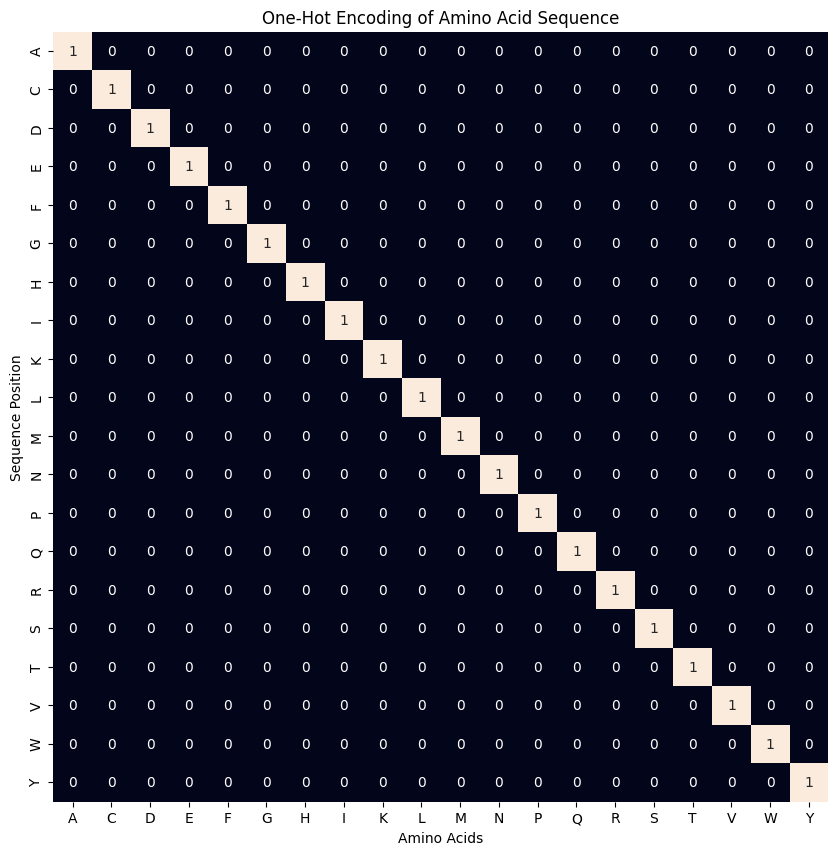

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_one_hot(encoded_seq, seq):
    # Create a heatmap from the one-hot encoded matrix
    plt.figure(figsize=(10, len(encoded_seq) / 2))
    sns.heatmap(encoded_seq, annot=True, cbar=False, cmap='rocket',
                xticklabels=list('ACDEFGHIKLMNPQRSTVWY'), yticklabels=list(seq))
    plt.xlabel('Amino Acids')
    plt.ylabel('Sequence Position')
    plt.title('One-Hot Encoding of Amino Acid Sequence')
    plt.show()

# Example usage
seq = "ACDEFGHIKLMNPQRSTVWY"
encoded_seq = one_hot_encode(seq)
visualize_one_hot(encoded_seq, seq)

In [150]:
def visualize_sequences(sequences):
    num_seqs = len(sequences)
    cols = min(num_seqs, 5)
    rows = (num_seqs - 1) // 5 + 1

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2))

    for i, seq in enumerate(sequences):
        encoded_seq = one_hot_encode(seq)
        ax = axs[i // 5, i % 5] if rows > 1 else axs[i]
        
        sns.heatmap(encoded_seq, annot=True, cbar=False, cmap='rocket', ax=ax,
                    xticklabels=list('ACDEFGHIKLMNPQRSTVWY'), yticklabels=list(seq))
        ax.set_title(f'Sequence {i+1}')
        ax.set_xlabel('Amino Acids')
        ax.set_ylabel('Position')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()

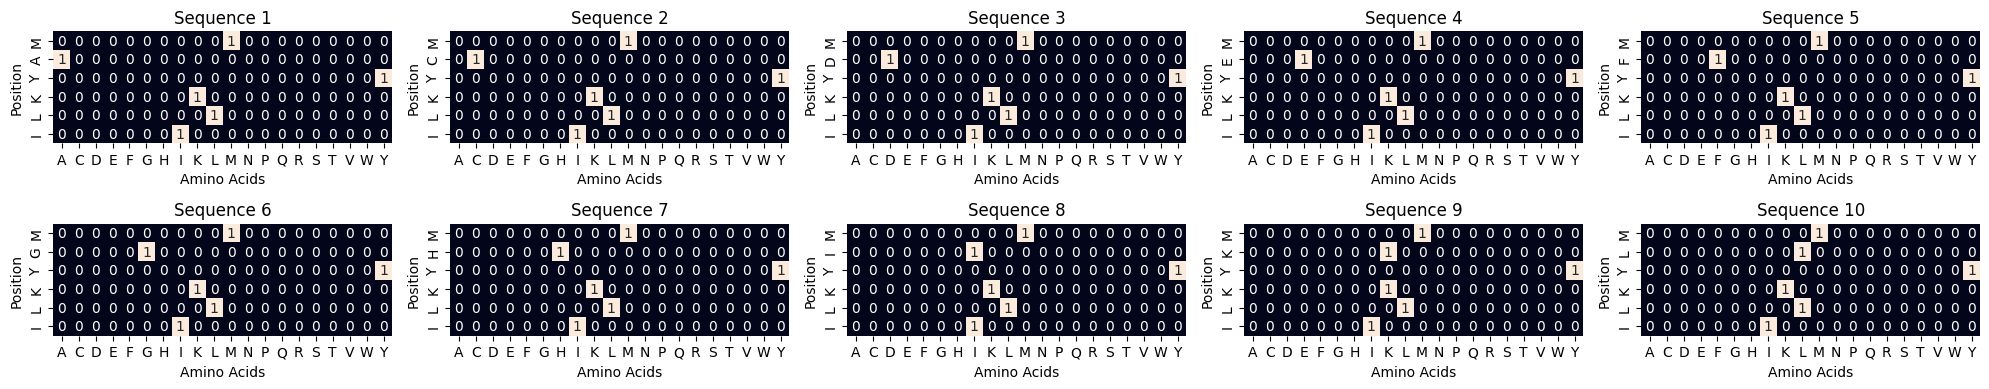

In [151]:
sequences = [seq[0:6] for seq in df.sequence.to_list()]
sequences = sequences[:10]

visualize_sequences(sequences) 

In [152]:
# encoding all sequences
df['encoded'] = df['sequence'].apply(one_hot_encode)

## Data Splitting
---
In the process of data splitting, we divide our dataset into three distinct sets, each serving a specific purpose:

1. **Training Set**: This set forms the cornerstone of model training. It's the portion of data used to teach the model how to make predictions or classifications. The model learns from the patterns and relationships within this set.

2. **Testing Set**: The testing set remains untouched during training and is reserved for evaluating the model's performance post-training, akin to a final exam. By assessing the model on this independent dataset, we can measure how well it generalizes to unseen data. This helps us gauge the model's real-world applicability.

3. **Validation Set**: Think of the validation set as a quality control mechanism. It aids in fine-tuning our model during training without dipping into the testing set, much like a practice test before the final exam. This set is used for model validation and hyperparameter tuning. We make adjustments to our model based on its performance on the validation set to ensure optimal results.

Data splitting is essential to ensure that our model isn't merely memorizing correct answers from the training data. By training on one portion of the data and testing on another, we can gauge how well the model is likely to perform on new, unseen data. This process helps us avoid overfitting, where the model becomes too specialized on the training data and performs poorly on new examples.

### Key Benefits of Data Splitting:

1. **Model Assessment**: Data splitting empowers us to assess how effectively our model performs on unseen data (the testing set) and make any necessary adjustments. It provides an objective measure of the model's real-world performance.

2. **Hyperparameter Tuning**: The validation set plays a pivotal role in fine-tuning model hyperparameters, ensuring that our model is optimized for the specific task. By adjusting hyperparameters like learning rates or network architectures based on validation set performance, we can achieve better model performance.

### Question
1. What would be the consequences if we chose not to split the data during training?


In [153]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [154]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, fitness_values):
        self.sequences = sequences
        self.fitness_values = fitness_values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        fitness = self.fitness_values[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(fitness, dtype=torch.float32)

# Prepare your dataset
X = np.stack(df['encoded'].values)
y = df['fitness'].values

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# check out shape
print(f'Training set has {X_train.shape[0]} observations.')
print(f'Validation set has {X_val.shape[0]} observations.')
print(f'Training set has {X_test.shape[0]} observations.')

# Create datasets
train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

Training set has 615 observations.
Validation set has 205 observations.
Training set has 206 observations.


## Neural Network Architecture
---
In the following we are going to define the feed-forward neural netwrok (FFNN) architecture used for our regression task. Notice that the network is designed in a flexible way, such that the hidden layers can be provided as a list of integer values to determine the number of neurons per hidden layer (e.g. [10, 10]). 

### Questions
1. What is the activation function used in this example?
2. What is the input dimension to the neural network (how many neurons are in the first layer)?
3. What is the output dimension of the FFNN (how many neurons are in the final layer)?

In [155]:
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(FFNN, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())

        # Add hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], 1))

        # Register all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

## The Training Loop
---
Training an Artificial Neural Network (ANN) is an iterative process, often involving a series of steps that are repeated for a number of epochs. An epoch is one complete pass through the entire training dataset. The Python function train you provided encapsulates this process, commonly known as the training loop. It systematically adjusts the model's parameters (weights and biases) based on the given data. Let's dissect the key components and their rationale:

### The Training Loop Structure
**Initialization of Loss Lists**: `train_losses` and `val_losses` are initialized to track the loss (a measure of prediction error) during training and validation phases across epochs.

**Iterating Over Epochs**: The loop for epoch in `range(num_epochs)` iterates over the dataset multiple times. Each epoch represents a complete pass through the training data.

### The Training Phase
Model in Training Mode: `model.train()` sets the model to training mode, enabling features like dropout and batch normalization which are specific to training.

**Batch Processing**: The training data is usually divided into batches (`sequences`, `fitness` in `train_loader`). Batches allow the model to update weights incrementally, improving convergence and efficiency.

**Forward Pass**: The model computes predictions `outputs = model(sequences)` for each batch.

**Calculating Loss**: The `criterion(outputs, fitness.unsqueeze(1))` calculates the loss, a measure of how far the model's predictions are from the actual values.

### Backward Pass and Optimization:

`loss.backward()` computes the gradient of the loss with respect to the model parameters.
`optimizer.step()` updates the weights based on these gradients.
`optimizer.zero_grad()` resets gradients to zero for the next batch.
**Tracking Training Loss**: The average loss per epoch is calculated and stored for later visualization and analysis.

### The Validation Phase
**Model in Evaluation Mode**: `model.eval()` sets the model to evaluation mode, disabling training-specific features like dropout.

**No Gradient Calculation**: with `torch.no_grad()` ensures that gradients are not computed during validation, reducing memory usage and speeding up computations.

**Validation Loss Calculation**: Similar to the training phase, but no weights are updated. It's used to assess the model's performance on unseen data.

## Visualizing Losses
**Plotting Losses**: Using Matplotlib, the function plots the training and validation losses over epochs. This visualization is crucial for understanding the model's learning process and convergence behavior.
The rationale behind this structured approach is to systematically optimize the model's ability to make accurate predictions. By training over multiple epochs, the network gradually improves its understanding of the complex relationships within the data. The validation phase is critical for ensuring that the model is not just memorizing the training data but is capable of generalizing to new, unseen data, a concept known as overfitting. This iterative process of training and validation is key to developing robust neural network models in fields like protein engineering, where accurate and generalizable models are essential.

## Questions
1. Describe the training loop. What happens in each segment?
2. What is the purpose of the validation phase?
3. What differentiates the validation phase from the training phase?

In [156]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    # Initialization
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    # viz model architecture
    print(summary(model))

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for sequences, fitness in train_loader:
            if len(sequences.shape) == 3:
                sequences = sequences.view(sequences.size(0), -1)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, fitness.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for sequences, fitness in val_loader:
                    sequences = sequences.view(sequences.size(0), -1)
                    outputs = model(sequences)
                    loss = criterion(outputs, fitness.unsqueeze(1))
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Check if this model has the best validation loss so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()

    # Plotting using Matplotlib
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    
    # Add a vertical dotted line at the epoch when the best model is saved
    if best_model is not None:
        best_epoch = val_losses.index(best_val_loss) + 1
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Return the best model state_dict
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return model

## A closer look: Hidden Layers and Optimizer

In the following section the model is actually trained. Play arround with the number of hidden layers and neurons per layer and try other optimizers. What do you notice?

1. What happens if you increase/decrease the number of neurons? You can try "extreme" examples, e.g. 1 neuron or 1000 neurons.
2. What effect does the optimizer have. Learn more about different optimizers [here](https://pytorch.org/docs/stable/optim.html).
4. What do you observe when testing the model on the test set?
5. How does the batch size affect learning?
6. What happens if you don't shuffle during training?

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       11,210
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       110
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       11
Total params: 11,331
Trainable params: 11,331
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       11,210
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       110
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       11
Total params: 11,331
Trainable params: 11,331
Non-trainable params: 0


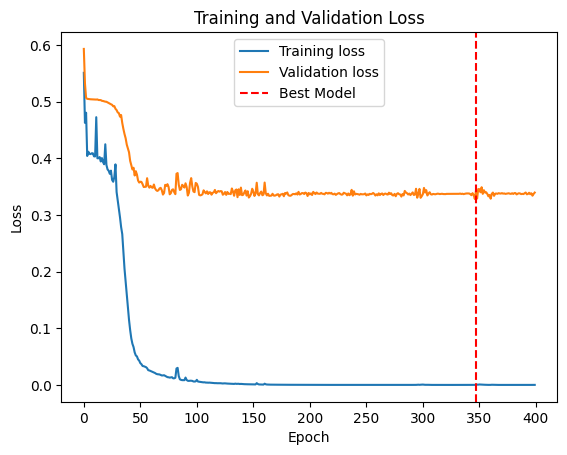

In [157]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model Architecture
input_size = X_train.shape[1] * X_train.shape[2]
model = FFNN(input_size, hidden_layers=[10, 10])

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
best_model = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=400)

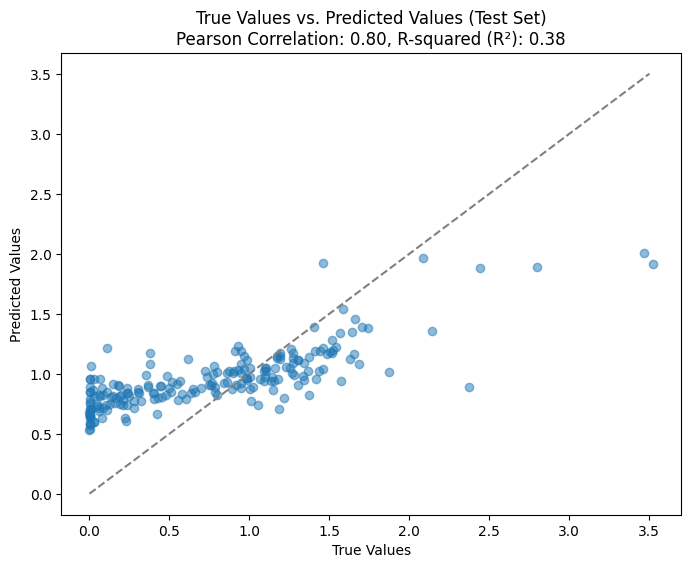

In [158]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score  # Import R-squared metric

# Compute true vs. predicted values using the test loader
best_model.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for sequences, fitness in test_loader:
        sequences = sequences.view(sequences.size(0), -1)
        outputs = best_model(sequences)
        true_values.extend(fitness.numpy())
        predicted_values.extend(outputs.squeeze(1).numpy())

# Calculate Pearson correlation coefficient
pearson_corr, _ = pearsonr(true_values, predicted_values)

# Calculate R-squared (R²) value
r_squared = r2_score(true_values, predicted_values)

# Plot a scatter plot of true vs. predicted values with diagonal line
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predicted_values, alpha=0.5)
plt.plot(np.arange(min(true_values), max(true_values), 0.1), 
         np.arange(min(true_values), max(true_values), 0.1), 
         linestyle='--', color='grey')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True Values vs. Predicted Values (Test Set)\n'
          f'Pearson Correlation: {pearson_corr:.2f}, R-squared (R²): {r_squared:.2f}')
plt.show()

## Data Transformations in Neural Networks: Principal Component Analysis (PCA)
---
In the realm of machine learning, and particularly in neural networks, preprocessing and transforming data is a crucial step. This is especially true in fields like biotechnology, where datasets can be vast and complex. One common challenge is dealing with sparse data, often arising from techniques like One-Hot Encoding (OHE) in protein sequence analysis. Principal Component Analysis (PCA) is a powerful tool for transforming such data, reducing sparsity, and extracting meaningful features.

### Understanding Principal Component Analysis (PCA)

The Essence of PCA: PCA is a statistical technique that simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the original variables into a new set of variables, the principal components, which are uncorrelated and which account for the maximum amount of variance in the data.

**Mathematical Framework**: Mathematically, PCA involves an eigenvalue decomposition of the data covariance matrix or singular value decomposition (SVD) of the data matrix. If we denote our data matrix as $X \in \mathbb{R}^{n \times m}$ (where $n$ is the number of samples and $m$ is the number of features), PCA seeks to find a transformation matrix $W$ that projects $X$ onto a lower-dimensional space. The principal components are then given by:

$PC=XW$

Here, the columns of $W$ are the eigenvectors of the covariance matrix of $X$, and they are ordered by the corresponding eigenvalues in descending order. The first few columns of $W$ (corresponding to the largest eigenvalues) are used to reduce the dimensionality of the data.

### PCA in the Context of Protein Engineering
Reducing Sparsity: In protein sequence analysis, where data is often encoded as sparse binary vectors (like in OHE), PCA can be used to reduce the dimensionality and sparsity. This transformation results in denser, continuous features that might capture more meaningful biological patterns with less computational cost.

**Enhancing Feature Extraction**: By focusing on the principal components, PCA emphasizes the features in the data that contribute most to its variance. This can be particularly useful in identifying the most significant patterns in protein sequences, aiding in more effective training of neural networks.

**Visualizing High-Dimensional Data**: PCA is also a valuable tool for visualization. By reducing data to two or three principal components, it allows for the visual exploration of complex datasets, providing insights that might not be apparent in higher dimensions.

### Practical Considerations
Choosing the Number of Components: A key decision in PCA is determining how many principal components to keep. This often involves a trade-off between reducing dimensionality and retaining enough information. Methods like the scree plot or explained variance ratio can guide this choice.

**Preprocessing**: Standardizing the data (to have zero mean and unit variance) is often a prerequisite for PCA, ensuring that the principal components reflect the correlations in the data rather than the scale of the variables.

**Integration with Neural Networks**: Post-PCA, the transformed data can be fed into neural networks. This can lead to faster training times and potentially better performance, as the network doesn't have to learn patterns from sparse, high-dimensional data.

In summary, PCA is a transformative tool in the preprocessing pipeline for neural network models, particularly in protein engineering. It not only tackles the challenge of sparsity and high dimensionality but also enhances the model's ability to learn significant biological patterns, making it a valuable technique in the data scientist's toolkit.

### Questions
---
1. What is the effect of dimensionality reduction via PCA on the model performance?
2. How do different number of components (`n_components`) affect the model performance?
3. Describe the differences between the transformed input data and the OHE.
4. What do you observe when testing the model on the test set?

In [159]:
from sklearn.decomposition import PCA

# Number of components
n_components = 60

# Prepare your dataset
X = np.stack(df['encoded'].values)
y = df['fitness'].values

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape the data to 2D format if needed
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create PCA models for each subset
pca = PCA(n_components=n_components).fit(X_train_flat)

# Transform the data using PCA
X_train_pca = pca.transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)

# Create datasets
train_dataset_pca = SequenceDataset(X_train_pca, y_train)
val_dataset_pca = SequenceDataset(X_val_pca, y_val)
test_dataset_pca = SequenceDataset(X_test_pca, y_test)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       610
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       110
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       11
Total params: 731
Trainable params: 731
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       610
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       110
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       11
Total params: 731
Trainable params: 731
Non-trainable params: 0


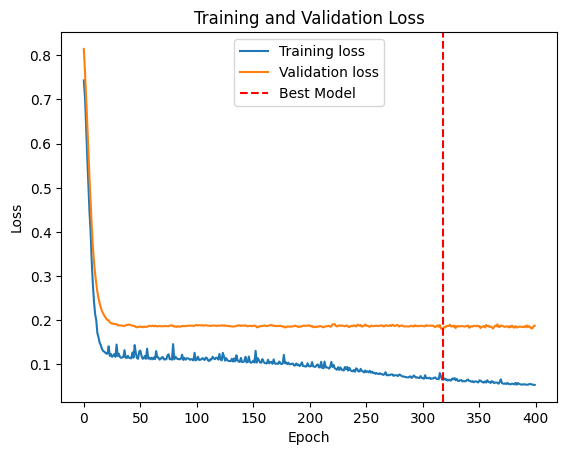

In [160]:
batch_size = 32
# Create DataLoaders
train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=batch_size, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

# Define the model Architecture
input_size = X_train_pca.shape[1]
model = FFNN(input_size, hidden_layers=[10, 10])

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
best_model_pca = train(model, train_loader_pca, val_loader_pca, criterion, optimizer, num_epochs=400)

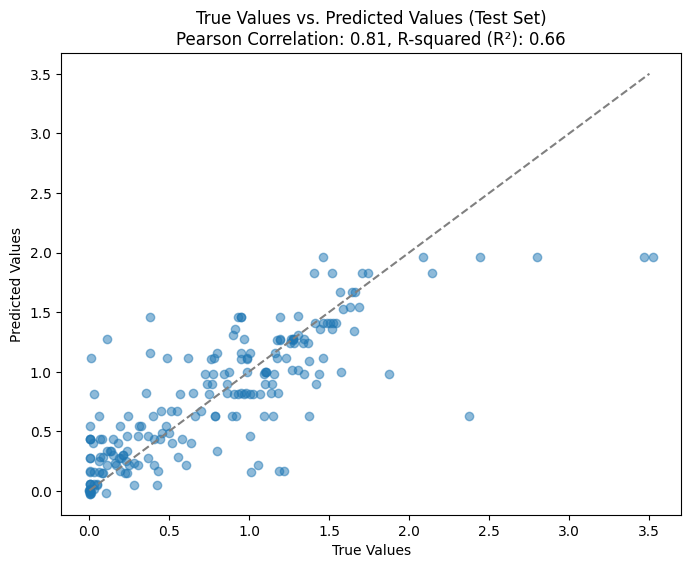

In [161]:
# Compute true vs. predicted values using the test loader
best_model_pca.eval()
true_values = []
predicted_values = []
with torch.no_grad():
    for sequences, fitness in test_loader_pca:
        sequences = sequences.view(sequences.size(0), -1)
        outputs = best_model_pca(sequences)
        true_values.extend(fitness.numpy())
        predicted_values.extend(outputs.squeeze(1).numpy())

# Calculate Pearson correlation coefficient
pearson_corr, _ = pearsonr(true_values, predicted_values)

# Calculate R-squared (R²) value
r_squared = r2_score(true_values, predicted_values)

# Plot a scatter plot of true vs. predicted values with diagonal line
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predicted_values, alpha=0.5)
plt.plot(np.arange(min(true_values), max(true_values), 0.1), 
         np.arange(min(true_values), max(true_values), 0.1), 
         linestyle='--', color='grey')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True Values vs. Predicted Values (Test Set)\n'
          f'Pearson Correlation: {pearson_corr:.2f}, R-squared (R²): {r_squared:.2f}')
plt.show()

## Take Home Messages
---
1. Proteins can be numerically expressed and used as inputs for machine learning algorithms.
2. One-hot encoding creates high-dimensional and sparse representations of protein sequences.
3. Training ANNs with gradient based learning:
   - Splitting data into train, validation and test sets.
   - The training loop consists of a train and validation phase. 
   - The purpose of validation is to estimate generalization and overfitting.
   - The test set "simulates" the models performance during inference.
   - There are many different optmization algorithms, which lead to different training behaviours.
5. The performance of machine learning models can be tracked with proper metrics and visualizations.
4. Transforming data to more meaningful spaces improves learning.